**Sistem Rekomendasi Buku dengan Model Development Content Based Filtering dan Collaborative Filtering**

Dataset: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset

# **Data Loading and Data Understanding**

In [1]:
# Import library
import pandas as pd
import numpy as np
import zipfile
import os

from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
!pip install -q kaggle

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fauzanbyu","key":"6315917ff5833a191af787ea7c399e2b"}'}

In [4]:
!mkdir BookRecommendation
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arashnic/book-recommendation-dataset -p /content/BookRecommendation/

 37% 9.00M/24.3M [00:00<00:00, 70.0MB/s]
100% 24.3M/24.3M [00:00<00:00, 131MB/s] 


In [5]:
!unzip '/content/BookRecommendation/book-recommendation-dataset.zip' -d /content/BookRecommendation/

Archive:  /content/BookRecommendation/book-recommendation-dataset.zip
  inflating: /content/BookRecommendation/Books.csv  
  inflating: /content/BookRecommendation/DeepRec.png  
  inflating: /content/BookRecommendation/Ratings.csv  
  inflating: /content/BookRecommendation/Users.csv  
  inflating: /content/BookRecommendation/classicRec.png  
  inflating: /content/BookRecommendation/recsys_taxonomy2.png  


Diketahui terdapat 3 berkas berformat csv yaitu: Books, Ratings, dan Users.

In [6]:
# Membuat variabel yang menampung data
Books = pd.read_csv('/content/BookRecommendation/Books.csv', low_memory=False)
Ratings = pd.read_csv('/content/BookRecommendation/Ratings.csv', low_memory=False)
Users = pd.read_csv('/content/BookRecommendation/Users.csv', low_memory=False)

Melihat 5 data teratas dari variabel Books.

In [7]:
Books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Melihat data variabel Ratings.

In [8]:
Ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


Melihat 5 data teratas dari variabel Users.

In [9]:
Users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


# **Exploratory Data Analysis - Univariate Analysis**

Variabel-variabel pada Book Recommendation Dataset adalah sebagai berikut:

- Books : Merupakan informasi seputar buku yang didalamnya terdapat fitur: judul buku, penulis buku, tahun publikasi buku, dan penerbit.
- Ratings : Berisi informasi penilaian terhadap buku. Penilaian (Book-Rating) bersifat eksplisit, dinyatakan dalam skala 1-10 (semakin tinggi nilai menunjukkan apresiasi yang lebih tinggi), atau implisit, yang dinyatakan dengan 0.
- Users : Berisi informasi seputar data
pengguna yang didalamnya terdapat fitur: ID user, lokasi, dan umur.

Variabel yang akan di eksplorasi pada proyek ini adalah variabel "Books" dan "Ratings". Sedangkan, variabel "Users" hanya digunakan untuk melihat bagaimana profile penguna.

## **Variabel Books**
Melakukan eksplorasi variabel "Books", yaitu informasi seputar buku.

In [10]:
# Mengecek informasi pada data variabel Books
Books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Berdasarkan output di atas, dapat diketahui bahwa "Books" memiliki kurang lebih 271359 entri. Terdapat 8 fitur, yaitu:
- ISBN (International Standard Book Number) adalah kode pengidentifikasian buku yang bersifat unik. Informasi tentang judul, penerbit, dan kelompok penerbit.
- Book-Title merupakan judul buku.
- Book-Author merupakan nama dari penulis buku.
- Year-Of-Publication merupakan tahun publikasi buku.
- Publisher merupakan pihak yang menerbitkan buku.
- Image-URL-S merupakan tautan dalam skala kecil (small).
- Image-URL-M merupakan tautan dalam skala sedang (medium).
- Image-URL-L merupakan tautan dalam skala besar (large).

Melihat banyak entri yang unik berdasarkan fitur 'Book-Title' dan beberapa judul buku yang unik.

In [11]:
# Melihat jumlah buku dan beberapa judul buku
print('Banyak Data :', len(Books['Book-Title'].unique()))
print('Judul Buku  :', Books['Book-Title'].unique())

Banyak Data : 242135
Judul Buku  : ['Classical Mythology' 'Clara Callan' 'Decision in Normandy' ...
 'Lily Dale : The True Story of the Town that Talks to the Dead'
 "Republic (World's Classics)"
 "A Guided Tour of Rene Descartes' Meditations on First Philosophy with Complete Translations of the Meditations by Ronald Rubin"]


Terdapat 242.135 jumlah buku yang unik dengan judul buku yang ada.

## **Variabel Ratings**
Melakukan eksplorasi variabel "Ratings", yaitu informasi seputar penilaian terhadap buku.

In [12]:
# Mengecek informasi pada data variabel "Ratings"
Ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Berdasarkan output di atas, dapat diketahui bahwa variabel Ratings memiliki banyak entri yaitu 1.149.780 entri. Terdapat 3 kolom yaitu: User-ID, ISBN, dan Book-Rating.

In [13]:
# Menampilkan data pada variabel "Ratings"
Ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


Dapat diketahui dari output diatas bahwa data "Ratings" terdiri dari 3 kolom/fitur dengan 1 kategori rating. Fitur-fitur tersebut antara lain:
- User-ID merupakan identitas pengguna.
- ISBN merupakan kode pengidentifikasian buku.
- Book-Rating merupakan informasi penilaian terhadap buku.

Selanjutnya melihat distribusi rating pada data.

In [14]:
Ratings.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,User-ID,Book-Rating
count,1149780.000000,1149780.000000
mean,140386.395126,2.866950
std,80562.277719,3.854184
min,2.000000,0.000000
25%,70345.000000,0.000000
50%,141010.000000,0.000000
75%,211028.000000,7.000000
max,278854.000000,10.000000


Dari output di atas, diketahui bahwa nilai maksimum rating pada fitur 'Book-Rating' adalah 10 dan nilai minimumnya adalah 0.

In [15]:
# Melihat berapa pengguna yang memberikan rating, jumlah ISBN, dan jumlah rating
print('Jumlah User-ID     :', len(Ratings['User-ID'].unique()))
print('Jumlah ISBN        :', len(Ratings['ISBN'].unique()))
print('Jumlah Data Rating :', len(Ratings))

Jumlah User-ID     : 105283
Jumlah ISBN        : 340556
Jumlah Data Rating : 1149780


## **Variabel Users**

Melihat berapa jumlah kolom dan baris pada variabel "Users".

In [16]:
print(Users.shape)

(278858, 3)


Melihat fitur apa saja yang terdapat pada variabel "Users".

In [17]:
Users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


# **Data Preprocessing**

Dapat dilihat sebelumnya bahwa sangat banyak entri pada masing-masing variabel, contohnya pada ariabel "Ratings" memiliki hingga 1.149.780 entri, dengan banyaknya entri akan memakan banyak penggunaan backend RAM gratis pada google colab, sehingga entri pada masing-masing variabel akan dikurangi menjadi 50.000 entri saja.

In [18]:
# Mengurangi entri pada masing-masing variabel
Books = Books[1:50001]
Ratings = Ratings[1:50001]
Users = Users[1:50001]

## **Menghapus Fitur yang Tidak Digunakan**

In [19]:
# Mengecek informasi pada data variabel "Books"
Books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 1 to 50000
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ISBN                 50000 non-null  object
 1   Book-Title           50000 non-null  object
 2   Book-Author          50000 non-null  object
 3   Year-Of-Publication  50000 non-null  object
 4   Publisher            50000 non-null  object
 5   Image-URL-S          50000 non-null  object
 6   Image-URL-M          50000 non-null  object
 7   Image-URL-L          50000 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


In [20]:
# Melihat jumlah buku dan beberapa judul buku
print('Banyak Data :', len(Books['Book-Title'].unique()))
print('Judul Buku  :', Books['Book-Title'].unique())

Banyak Data : 46241
Judul Buku  : ['Clara Callan' 'Decision in Normandy'
 'Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It'
 ... "The Flight of the Stoneman's Son (The Flight of the Stoneman)"
 'Son a Smaller Hero (New Canadian Library)'
 'Labyrinths of Light (Munsey, Terence. Stoneman Series, Bk. 3.)']


Menghapus fitur pada variabel "Books" yaitu: 'Image-URL-S', 'Image-URL-M', dan 'Image-URL-L' karena ketiga fitur tersebut tidak akan digunakan dan tidak memiliki pengaruh terhadap rekomendasi buku.

In [21]:
# Menghapus fitur yang tidak digunakan pada variabel Books
Books = Books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1)

Books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
...,...,...,...,...,...
49996,0969706618,The Keeper of Three (The Stoneman Series),Terence Munsey,1994,Munsey Music
49997,096970660X,The Flight of the Stoneman's Son (The Flight o...,Terence Munsey,1993,Munsey Music
49998,0771099703,Son a Smaller Hero (New Canadian Library),M. Richler,1989,New Canadian Library
49999,0441873251,Warlock Unlocked,Christopher Stasheff,1982,Penguin Putnam~mass


## **Menggabungkan Buku**

Menggunakan fitur 'ISBN' yang unik sebagai acuan dalam penggabungan.

In [22]:
# Menggabungkan seluruh fitur 'ISBN' pada kategori Books
Books_all = np.concatenate((
    Books.ISBN.unique(),
    Ratings.ISBN.unique()
))

# Mengurutkan data dan menghapus data yang sama
Books_all = np.sort(np.unique(Books_all))

print('Jumlah seluruh data buku berdasarkan ISBN :', len(Books_all))

Jumlah seluruh data buku berdasarkan ISBN : 62808


Setelah penggabungan, didapatkan 62.808 data  ISBN yang unik.

## **Menggabungkan Seluruh User**

Menggunakan fitur 'User-ID' yang unik sebagai acuan dalam penggabungan.

In [23]:
# Menggabungkan seluruh fitur 'User_ID'
Users_all = np.concatenate((
    Users['User-ID'].unique(),
    Ratings['User-ID'].unique()
))

# Menghapus data yang sama kemudian mengurutkannya
Users_all = np.sort(np.unique(Users_all))

print('Jumlah seluruh user :', len(Users_all))

Jumlah seluruh user : 50849


Setelah penggabungan, didapatkan 50.849 data User-ID yang unik.

## **Mengetahui Jumlah Rating**

In [24]:
# Mendefinisikan dataframe "Ratings" ke dalam variabel "all_Books_rate"
all_Books_rate = Ratings.copy()
all_Books_rate.drop(all_Books_rate[all_Books_rate['Book-Rating'] == 0].index, inplace=True)
all_Books_rate

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
49988,11676,0445006226,8
49992,11676,0445046368,4
49995,11676,0445405457,7
49999,11676,0445409207,5


Dari output diatas dapat diketahui hanya tersisa 20.963 baris dan 3 kolom

In [25]:
# Menggabungkan dataframe "Ratings" dengan "Books" berdasarkan nilai 'ISBN'
all_Books = pd.merge(all_Books_rate, Books, on='ISBN', how='left')

all_Books

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276726,0155061224,5,NaN,NaN,NaN,NaN
1,276729,052165615X,3,NaN,NaN,NaN,NaN
2,276729,0521795028,6,NaN,NaN,NaN,NaN
3,276736,3257224281,8,NaN,NaN,NaN,NaN
4,276737,0600570967,6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
20958,11676,0445006226,8,NaN,NaN,NaN,NaN
20959,11676,0445046368,4,Life Before Man,Margaret Atwood,0,Warner Books> C/o Little Br
20960,11676,0445405457,7,NaN,NaN,NaN,NaN
20961,11676,0445409207,5,NaN,NaN,NaN,NaN


Variabel setelah dilakukan merge sangat banyak. Diketahui juga terdapat banyak sekali missing value.

In [26]:
# Mengecek missing value dengan fungsi isnull()
all_Books.isnull().sum()

User-ID                   0
ISBN                      0
Book-Rating               0
Book-Title             5287
Book-Author            5287
Year-Of-Publication    5287
Publisher              5287
dtype: int64

Dari output diatas, terdapat banyak missing value pada 4 fitur. Hanya fitur User-ID, ISBN, dan Book-Rating saja yang memiliki 0 missing value.

Selanjutnya, menghitung jumlah rating berdasarkan ISBN

In [27]:
# Menghitung jumlah rating kemudian menggabungkannya berdasarkan 'ISBN'
all_Books.groupby('ISBN').sum(numeric_only=True)

,User-ID,Book-Rating
ISBN,,
9022906116,11676,7
0/330/25864/8,11174,9
00 14 02 5314,5091,6
0000000000,19770,19
00000000000,11676,8
...,...,...
O6712345670,277305,7
O809463121,1582,5
"\0210000010""",4377,8


# **Data Preparation**

## **Mengatasi Missing Value**

Mengecek lagi datanya apakah ada missing value atau tidak setelah proses penggabungan.

In [28]:
all_Books

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276726,0155061224,5,NaN,NaN,NaN,NaN
1,276729,052165615X,3,NaN,NaN,NaN,NaN
2,276729,0521795028,6,NaN,NaN,NaN,NaN
3,276736,3257224281,8,NaN,NaN,NaN,NaN
4,276737,0600570967,6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
20958,11676,0445006226,8,NaN,NaN,NaN,NaN
20959,11676,0445046368,4,Life Before Man,Margaret Atwood,0,Warner Books> C/o Little Br
20960,11676,0445405457,7,NaN,NaN,NaN,NaN
20961,11676,0445409207,5,NaN,NaN,NaN,NaN


In [29]:
# Mengecek missing value dengan fungsi isnull()
all_Books.isnull().sum()

User-ID                   0
ISBN                      0
Book-Rating               0
Book-Title             5287
Book-Author            5287
Year-Of-Publication    5287
Publisher              5287
dtype: int64

Dari output diatas dapat diketahui, terdapat 5.287 dari 20.963 missing value pada fitur 'Book-Title' (judul buku), ''Book-Author' (penulis), Year-Of-Publication' (tahun publikasi buku), dan 'Publisher' (penerbit).

Langkah selanjutnya adalah melakukan drop pada data yang memiliki missing value.

In [30]:
# Membersihkan missing value dengan fungsi dropna()
all_Books_clean = all_Books.dropna()
all_Books_clean

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
5,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001,Doubleday
7,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch
8,276747,0671537458,9,Waiting to Exhale,Terry McMillan,1995,Pocket
9,276747,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,1997,Vintage Books USA
13,276751,3596218098,8,Reise nach Ixtlan. Die Lehre des Don Juan.,Carlos Castaneda,1998,"Fischer (Tb.), Frankfurt"
...,...,...,...,...,...,...,...
20951,11676,0441569595,8,Neuromancer (Remembering Tomorrow),William Gibson,1995,Ace Books
20952,11676,0441586333,1,Norby Chronicles,Isaac Asimov,1986,Ace Books
20953,11676,0441627404,4,The Once and Future King,T. H. White,1987,Ace Books
20955,11676,0441790348,8,Stranger in a Strange Land (Remembering Tomorrow),Robert A. Heinlein,1995,ACE Charter


Dapat diketahui hanya tersisa 15.676 baris data setelah dilakukan pembersihan missing value.

In [31]:
# Mengecek kembali missing value pada variabel "all_Books_clean"
all_Books_clean.isnull().sum()

User-ID                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

Dapat diketahui sudah tidak ada missing value pada ketiga fitur tersebut.

Langkah selanjutnya, membuat variabel "preparation" yang berisi dataframe "all_books_clean" kemudian mengurutkan berdasarkan 'ISBN'.

In [32]:
preparation = all_Books_clean
preparation.sort_values('ISBN')

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
16310,10067,0001360469,10,Babe Dressing,Mandy Stanley,1997,HarperCollins Publishers
16311,10067,0001374869,10,Baby Plays (Collins Baby and Toddler Series),Fiona Pragoff,1994,HarperCollins Publishers
2399,8,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
18053,11676,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
10228,6242,0002244098,5,Dust to dust: Stories,Timothy Findley,1997,HarperCollins
...,...,...,...,...,...,...,...
8645,4525,9879630130,5,Menos Tu Vientre,Miguel Hernandez,1997,Ameghino
6379,3326,9972847012,3,Los amigos que perdÃ­,Jaime Bayly,2000,Santillana USA Publishing Company
16389,10118,B0000633PU,8,The Story of Aladdin and the Wonderful Lamp,S. Lane Poole,0,Renaissance eBooks
15395,9029,B0000A2U93,7,Carmilla,Joseph Sheridan Le Fanu,0,Soft Editions Ltd


Selanjutnya, hanya akan digunakan data unik untuk dimasukkan ke dalam proses pemodelan. Oleh karena itu, perlu menghapus data yang duplikat. Dalam hal ini, fitur 'ISBN' yang duplikat akan dibuang.

In [33]:
# Membuang data 'ISBN' yang duplikat pada variabel "preparation"
preparation = preparation.drop_duplicates('ISBN')
preparation

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
5,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001,Doubleday
7,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch
8,276747,0671537458,9,Waiting to Exhale,Terry McMillan,1995,Pocket
9,276747,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,1997,Vintage Books USA
13,276751,3596218098,8,Reise nach Ixtlan. Die Lehre des Don Juan.,Carlos Castaneda,1998,"Fischer (Tb.), Frankfurt"
...,...,...,...,...,...,...,...
20933,11676,0441007732,10,"The Legend of Luke (Redwall, Book 12)",Brian Jacques,2001,Ace Books
20939,11676,044100914X,3,Castaways of the Flying Dutchman,Brian Jacques,2002,Ace Books
20944,11676,0441172695,10,"Dune Messiah (Dune Chronicles, Book 2)",Frank Herbert,1994,ACE Charter
20952,11676,0441586333,1,Norby Chronicles,Isaac Asimov,1986,Ace Books


Selanjutnya, melakukan konversi data series menjadi list.

In [34]:
# Mengonversi data series menjadi list
Books_id = preparation['ISBN'].tolist()
Books_title = preparation['Book-Title'].tolist()
Books_author = preparation['Book-Author'].tolist()
Books_year = preparation['Year-Of-Publication'].tolist()
Books_publisher = preparation['Publisher'].tolist()

print('ISBN                :', len(Books_id))
print('Books Title         :', len(Books_title))
print('Books Author        :', len(Books_author))
print('Year Of Publication :', len(Books_year))
print('Publisher           :', len(Books_publisher))

ISBN                : 11662
Books Title         : 11662
Books Author        : 11662
Year Of Publication : 11662
Publisher           : 11662


Tahap berikutnya, sebelum masuk ke tahap pemodelan, akan dibuat dictionary untuk menentukan pasangan key-value pada data 'Books_id', 'Books_title', 'Books_author', 'Books_year', dan 'Books_publisher' yang telah disiapkan sebelumnya.

In [35]:
# Membuat dictionary untuk data 'Books_id', 'Books_title', 'Books_author', 'Books_year', dan 'Books_publisher'
Books_new = pd.DataFrame({
    'id': Books_id,
    'Books_title': Books_title,
    'Books_author': Books_author,
    'Books_year': Books_year,
    'Books_publisher': Books_publisher
})

Books_new

,id,Books_title,Books_author,Books_year,Books_publisher
0,038550120X,A Painted House,JOHN GRISHAM,2001,Doubleday
1,0060517794,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch
2,0671537458,Waiting to Exhale,Terry McMillan,1995,Pocket
3,0679776818,Birdsong: A Novel of Love and War,Sebastian Faulks,1997,Vintage Books USA
4,3596218098,Reise nach Ixtlan. Die Lehre des Don Juan.,Carlos Castaneda,1998,"Fischer (Tb.), Frankfurt"
...,...,...,...,...,...
11657,0441007732,"The Legend of Luke (Redwall, Book 12)",Brian Jacques,2001,Ace Books
11658,044100914X,Castaways of the Flying Dutchman,Brian Jacques,2002,Ace Books
11659,0441172695,"Dune Messiah (Dune Chronicles, Book 2)",Frank Herbert,1994,ACE Charter
11660,0441586333,Norby Chronicles,Isaac Asimov,1986,Ace Books


# **Model Development dengan Content Based Filtering**

Mengecek lagi data yang dimiliki dan assign dataframe dari tahap sebelumnya ke dalam variabel "data_books".

In [36]:
data_books = Books_new

data_books.sample(10)

,id,Books_title,Books_author,Books_year,Books_publisher
7684,0448095238,Mystery of the Tolling Bell (Nancy Drew Myster...,Carolyn Keene,1973,Grosset &amp; Dunlap
1656,0741402912,Finding Dad,Jonathan Pearce,1999,Infinity Publishing (PA)
7374,0843951036,No Sanctuary,Richard Laymon,2003,Leisure Books
6269,0064402053,"Sarah, Plain and Tall (Sarah, Plain and Tall)",Patricia MacLachlan,2004,HarperTrophy
4457,0385499094,Akhenaten : Dweller in TruthA Novel,Naguib Mahfouz,2000,Anchor Pub
8603,006095129X,De Amor y de Sombra,Isabel Allende,1995,Rayo
9191,0312312261,"Are You Hungry, Dear?: Life, Laughs, and Lasagna",Doris Roberts,2003,St. Martin's Press
4970,0373109040,"Unbreakable Bond (Harlequin Presents, No 904)",Robyn Donald,1986,Harlequin
9351,0060956135,The Cloud Sketcher: A Novel,Richard Rayner,2002,Perennial
241,0060393823,Lost,Gregory Maguire,2001,ReganBooks


## **TF-IDF Vectorizer**
Pada tahap ini, membangun sistem rekomendasi sederhana berdasarkan judul buku yang tersedia.

In [37]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()
tf.fit(data_books['Books_title'])

# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(data_books['Books_title'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(11662, 12540)

Diketahui matriks memiliki ukuran (11.662, 12.540). Nilai 11.662 merupakan ukuran data sedangkan, 12.540 merupakan matrik judul buku.

Langkah selanjutnya, menghasilkan vektor tf-idf dalam bentuk matriks.

In [38]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Melihat matriks tf-idf untuk beberapa judul buku ('Books_title').

In [39]:
# Membuat dataframe untuk melihat tf-idf matrix
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=data_books.Books_title
).sample(12540, axis=1).sample(10, axis=0)

,phoebe,commandment,shockball,inglã,gingerbread,accurst,homo,first,genã,racã³,...,roots,share,hallmark,unlawfully,female,xxe,based,mila,lonesome,wider
Books_title,,,,,,,,,,,,,,,,,,,,,
Harry Potter and the Chamber of Secrets (Book 2),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tuck Everlasting,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bar sport duemila (I narratori/Feltrinelli),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Margin of the Bulls,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Witness for the Prosecution and Other Stories,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
First Avenue,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.577255,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Mermaids Singing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Lady Oscar : La Rose de Versailles, tome 2",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Privileged Information,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Cosine Similarity**
Menghitung derajat kesamaan (similarity degree) antar buku dengan teknik cosine similarity.

In [40]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)

cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.16099818,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.16099818, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

Selanjutnya, melihat matriks kesamaan setiap buku dengan menampilkan judul buku dalam 10 sampel kolom (axis=1) dan 10 sampel baris (axis=0).

In [42]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul buku
cosine_sim_df = pd.DataFrame(cosine_sim, index=data_books['Books_title'], columns=data_books['Books_title'])

print('Shape :', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap buku
cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Shape : (11662, 11662)


Books_title,The Fiancee and Other Stories (Penguin Classics),Claws and Effect,Running with Scissors,Moby Dick 2VOL,Tales of the Unexpected,Life Before Man,Pokemon Tales : Where's Clefairy's Voice? (Pokemon Tales),"RUSSIA HOUSE, THE","Circulos de Piedra, Los",The Year They Burned the Books
Books_title,,,,,,,,,,
"The Veil of a Thousand Tears (The Pearl Saga, Book 2)",0.028130,0.000000,0.0,0.0,0.070931,0.0,0.0,0.039913,0.000000,0.055089
Ghosts of the Fireground : Echoes of the Great Peshtigo Fire and the Calling of a Wildland Firefighter,0.055239,0.030808,0.0,0.0,0.105135,0.0,0.0,0.040529,0.000000,0.055938
Fat Girls and Lawn Chairs,0.044390,0.051267,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
Murder Runs in the Family: A Southern Sisters Mystery,0.015284,0.000000,0.0,0.0,0.020823,0.0,0.0,0.021686,0.000000,0.029931
Falso Movimiento (Gran Angular),0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
Crooked Little Heart,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
El Nombre De La Rosa/The Name Of The Rose,0.027693,0.000000,0.0,0.0,0.069829,0.0,0.0,0.039293,0.089159,0.054233
Das Geheimnis des siebten Weges,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
James Herriot's Cat Stories,0.125587,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000


Dapat diketahui pada output diatas. Angka yang mendekati 1.0 mengindikasikan bahwa judul buku pada baris Y (vertikal) memiliki kemiripan dengan judul buku pada kolom X (horizontal). Sebagai contoh, buku **The Fiancee and Other Stories (Penguin Classics)** teridentifikasi mirip dengan buku **James Herriot's Cat Stories**.

Dengan data kesamaan (similarity) judul buku yang diperoleh sebelumnya, selanjutnya akan dilakukan rekomendasi daftar judul buku yang mirip (similar) dengan judul buku yang sebelumnya pernah dibaca pengguna.

## **Mendapatkan Rekomendasi**
Menghasilkan sejumlah buku yang akan direkomendasikan kepada pengguna.

Sebagai contoh, pengguna X pernah membaca buku **The little PC Book Windows XP Edition**. Kemudian, saat pengguna tersebut berencana untuk membaca buku lain, sistem akan merekomendasikan buku lain yang memiliki kemiripan dengan buku yang pernah dibaca sebelumnya. Rekomendasi buku ini berdasarkan kesamaan yang dihitung dengan cosine similarity pada tahap sebelumnya.

Adapun fungsi books_recommendations dengan beberapa parameter sebagai berikut:

- Books_judul : Judul buku (index kemiripan dataframe).
- similarity_data : Dataframe mengenai similarity yang telah didefinisikan sebelumnya.
- items : Nama dan fitur yang digunakan untuk mendefinisikan kemiripan.
- k : Banyak rekomendasi yang ingin diberikan.

Keluaran sistem rekomendasi adalah berupa top-N recommendation. Oleh karena itu, akan memberikan sejumlah rekomendasi buku pada pengguna yang diatur dalam parameter k.

In [43]:
# Rekomendasi judul buku berdasarkan kemiripan dataframe
def Books_recommendations(Books_judul, similarity_data=cosine_sim_df, items=data_books[['Books_author', 'Books_title', 'Books_year', 'Books_publisher']], k=10):

  # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
  # Dataframe diubah menjadi numpy
  # Range(start, stop, step)
  index = similarity_data.loc[:,Books_judul].to_numpy().argpartition(
      range(-1, -k, -1))

  # Mengambil data dengan similarity terbesar dari index yang ada
  closest = similarity_data.columns[index[-1:-(k+2):-1]]

  # Drop Books_judul agar judul buku yang dicari tidak muncul dalam daftar rekomendasi
  closest = closest.drop(Books_judul, errors='ignore')

  return pd.DataFrame(closest).merge(items).head(k)

Menemukan rekomendasi yang mirip dengan buku Waking Up Screaming: Haunting Tales of Terror.

In [44]:
data_books[data_books.Books_title.eq('Waking Up Screaming: Haunting Tales of Terror')]

,id,Books_title,Books_author,Books_year,Books_publisher
1742,034545829X,Waking Up Screaming: Haunting Tales of Terror,H. P. Lovecraft,2003,Del Rey Books


Mendapatkan books recommendation dengan memanggil fungsi yang telah didefinisikan sebelumnya.

In [45]:
# Mendapatkan rekomendasi buku yang mirip dengan judul buku Waking Up Screaming: Haunting Tales of Terror
Books_recommendations('Waking Up Screaming: Haunting Tales of Terror')

,Books_title,Books_author,Books_year,Books_publisher
0,The Haunting,Paul Doherty,1998,Headline
1,Waking Beauty,Paul Witcover,1997,Harpercollins
2,Tales of Terror and the Supernatural,Wilkie Collins,1972,Dover Publications
3,Magic Terror: Seven Tales,Peter Straub,2001,Fawcett Books
4,A Winter Haunting,Dan Simmons,2002,HarperTorch
5,Haunting Rachel,KAY HOOPER,1999,Bantam
6,CHRISTOPHER PIKE'S TALES OF TERROR #2,Christopher Pike,1998,Simon Pulse
7,The Haunting of Hill House,Shirley Jackson,1984,Penguin Books
8,Great Tales of Terror (A Watermill Classic),Edgar Allan Poe,1993,Troll Communications
9,Tales Of Passion Tales Of Woe,Sandra Gulland,1999,Touchstone


Berdasarkan output hasil rekomendasi buku diatas, dapat diketahui bahwa dari 10 buku yang direkomendasikan memiliki kemiripan dengan buku dengan judul Waking Up Screaming: Haunting Tales of Terror.

## **Evaluasi Content-Based Filtering**
Adapun langkah yang digunakan untuk mendapatkan rekomendasi yaitu dengan menggunakan Top-N Recommendation untuk mengambil k dengan nilai similarity terbesar pada index matrix yang diberikan. Langkah pertama yaitu mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan yang kemudian dataframe akan diubah menjadi numpy, dengan menggunakan argpartition di ambil sejumlah nilai k tertinggi dari similarity, dalam kasus ini digunakan dataframe cosine similarity, Kemudian, mengambil data dari bobot (tingkat kesamaan) tertinggi ke terendah, kemudian menghapus judul buku agar nantinya judul buku yang dicari tidak muncul pada daftar rekomendasi buku.

Dalam kasus ini, mencari judul buku yang mirip dengan Waking Up Screaming: Haunting Tales of Terror, sehingga perlu drop judul buku tersebut agar tidak muncul dalam daftar rekomendasi yang diberikan nanti.  

# **Model Development dengan Collaborative Filtering**
Pada teknik Collaborative Filtering akan dapat menghasilkan rekomendasi sejumlah judul buku yang sesuai dengan preferensi pengguna berdasarkan rating yang telah diberikan pengguna sebelumnya. Dari data rating pengguna tersebut, akan diidentifikasi judul buku yang mirip dan belum pernah dikunjungi oleh pengguna untuk direkomendasikan.

## **Data Understanding**

In [46]:
# Import library yang dibutuhkan
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

Untuk memudahkan agar tidak tertukar dengan variabel "all_Books_rate" pada data, dibuat variabel "df" yang berisi data "all_Books_rate".

In [47]:
# Membaca dataset
df = all_Books_rate
df

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
49988,11676,0445006226,8
49992,11676,0445046368,4
49995,11676,0445405457,7
49999,11676,0445409207,5


## **Data Preparation**

Melakukan persiapan data untuk menyandikan (encode) fitur 'User-ID' dan 'ISBN' ke dalam indeks integer.

In [48]:
# Mengubah 'User-ID' menjadi list tanpa nilai yang sama
Users_ids = df['User-ID'].unique().tolist()

# Melakukan encoding 'User-ID'
Users_to_Users_encoded = {x: i for i, x in enumerate(Users_ids)}

# Melakukan proses encoding angka ke 'User-ID'
Users_encoded_to_Users = {i: x for i, x in enumerate(Users_ids)}

# Menampilkan hanya 10 baris pertama
print('List User-ID             :', Users_ids[:10])
print('Encoded User-ID          :', {k: Users_to_Users_encoded[k] for k in list(Users_to_Users_encoded)[:10]})
print('Encoded Angka ke User-ID :', {k: Users_encoded_to_Users[k] for k in list(Users_encoded_to_Users)[:10]})


List User-ID             : [276726, 276729, 276736, 276737, 276744, 276745, 276747, 276748, 276751, 276754]
Encoded User-ID          : {276726: 0, 276729: 1, 276736: 2, 276737: 3, 276744: 4, 276745: 5, 276747: 6, 276748: 7, 276751: 8, 276754: 9}
Encoded Angka ke User-ID : {0: 276726, 1: 276729, 2: 276736, 3: 276737, 4: 276744, 5: 276745, 6: 276747, 7: 276748, 8: 276751, 9: 276754}


Selanjutnya, melakukan hal yang sama pada fitur 'ISBN'.

In [49]:
# Mengubah 'ISBN' menjadi list tanpa nilai yang sama
Books_ids = df['ISBN'].unique().tolist()

# Melakukan encoding 'ISBN'
Books_to_Books_encoded = {x: i for i, x in enumerate(Books_ids)}

# Melakukan proses encoding angka ke 'ISBN'
Books_encoded_to_Books = {i: x for i, x in enumerate(Books_ids)}

# Menampilkan hanya 10 baris pertama
print('List ISBN             :', Books_ids[:10])
print('Encoded ISBN          :', {k: Books_to_Books_encoded[k] for k in list(Books_to_Books_encoded)[:10]})
print('Encoded Angka ke ISBN :', {k: Books_encoded_to_Books[k] for k in list(Books_encoded_to_Books)[:10]})

List ISBN             : ['0155061224', '052165615X', '0521795028', '3257224281', '0600570967', '038550120X', '342310538', '0060517794', '0671537458', '0679776818']
Encoded ISBN          : {'0155061224': 0, '052165615X': 1, '0521795028': 2, '3257224281': 3, '0600570967': 4, '038550120X': 5, '342310538': 6, '0060517794': 7, '0671537458': 8, '0679776818': 9}
Encoded Angka ke ISBN : {0: '0155061224', 1: '052165615X', 2: '0521795028', 3: '3257224281', 4: '0600570967', 5: '038550120X', 6: '342310538', 7: '0060517794', 8: '0671537458', 9: '0679776818'}


Berikutnya, memetakan 'User-ID' dan 'ISBN' ke dataframe yang berkaitan.

In [50]:
# Mapping 'User-ID' ke dataframe "Users"
df['Users'] = df['User-ID'].map(Users_to_Users_encoded)

# Mapping 'ISBN' ke dataframe "Books"
df['Books'] = df['ISBN'].map(Books_to_Books_encoded)

Terakhir, mengecek beberapa hal dalam data seperti jumlah user, jumlah buku, dan mengubah nilai rating menjadi float.

In [51]:
# Mendapatkan jumlah Users
num_Users = len(Users_to_Users_encoded)

# Mendapatkan jumlah Books
num_Books = len(Books_encoded_to_Books)

# Mengubah rating menjadi nilai float
df['Book-Rating'] = df['Book-Rating'].values.astype(np.float32)

# Nilai minimum Ratings
min_Ratings = min(df['Book-Rating'])

# Nilai maksimum Ratings
max_Ratings = max(df['Book-Rating'])

print('Number of Users  :', num_Users)
print('Number of Books  :', num_Books)
print('Maximum Ratings  :', max_Ratings)
print('Minimum Ratings  :', min_Ratings)
print('')

Number of Users  : 3786
Number of Books  : 16752
Maximum Ratings  : 10.0
Minimum Ratings  : 1.0



Tahap persiapan telah selesai. Berikut adalah hal-hal yang telah dilakukan pada tahap ini:

- Memahami data rating yang dimiliki.
- Menyandikan (encode) fitur 'User' dan 'ISBN' ke dalam indeks integer.
- Memetakan 'User-ID' dan 'ISBN' ke dataframe yang berkaitan.
- Mengecek beberapa hal dalam data seperti jumlah users, jumlah buku, dan mengubah nilai rating menjadi float.

## **Membagi Data untuk Training dan Validasi**

Mengacak datanya terlebih dahulu agar distribusinya menjadi random.

In [52]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,User-ID,ISBN,Book-Rating,Users,Books
28033,6563,0812967240,7.0,2418,9775
31261,7286,0689829507,10.0,2642,10634
29985,7105,0099422794,6.0,2581,10309
10306,254,0679879242,8.0,696,2553
24051,5582,0553584782,10.0,2136,8475
...,...,...,...,...,...
27984,6563,059035342X,8.0,2418,1567
29760,6910,0609804618,9.0,2530,10216
15435,2313,0385470142,9.0,1266,4907
2039,277478,0312979533,7.0,215,846


Selanjutnya, membagi data train dan validasi dengan komposisi 80:20. Namun sebelumnya, perlu untuk memetakan (mapping) data user dan buku menjadi satu value terlebih dahulu. Lalu, membuat rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training, agar nantinya data akan siap untuk dimasukkan ke dalam model.

In [53]:
# Membuat variabel x untuk mencocokkan data user dan buku menjadi satu value
x = df[['Users', 'Books']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['Book-Rating'].apply(lambda x: (x - min_Ratings) / (max_Ratings - min_Ratings)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 2418  9775]
 [ 2642 10634]
 [ 2581 10309]
 ...
 [ 1266  4907]
 [  215   846]
 [ 3206 12982]] [0.66666667 1.         0.55555556 ... 0.88888889 0.66666667 0.77777778]


## **Proses Training**
Pada tahap ini, model menghitung skor kecocokan antara pengguna dan buku dengan teknik embedding. Pertama, melakukan proses embedding terhadap data user dan buku. Selanjutnya, melakukan operasi perkalian dot product antara embedding user dan buku. Selain itu, juga menambahkan bias untuk setiap user dan buku. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

Pada tahap ini membuat class RecommenderNet dengan keras Model class. Kode class RecommenderNet ini terinspirasi dari tutorial dalam situs [Keras](https://keras.io/examples/structured_data/collaborative_filtering_movielens/) dengan beberapa adaptasi sesuai kasus yang sedang diselesaikan.

In [54]:
# Membuat class RecommenderNet dengan keras Model class
class RecommenderNet(tf.keras.Model):

  # Inisialisasi fungsi
  def __init__(self, num_Users, num_Books, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_Users = num_Users
    self.num_Books = num_Books
    self.embedding_size = embedding_size
    self.Users_embedding = layers.Embedding(   # Layer embedding Users
        num_Users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.Users_bias = layers.Embedding(num_Users, 1)   # Layer embedding Users bias
    self.Books_embedding = layers.Embedding(   # Layer embedding Books
        num_Books,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.Books_bias = layers.Embedding(num_Books, 1)   # Layer embedding Books bias

  def call(self, inputs):
    Users_vector = self.Users_embedding(inputs[:, 0])   # Memanggil layer embedding 1
    Users_bias = self.Users_bias(inputs[:, 0])   # Memanggil layer embedding 2
    Books_vector = self.Books_embedding(inputs[:, 1])   # Memanggil layer embedding 3
    Books_bias = self.Books_bias(inputs[:, 1])   # Memanggil layer embedding 4

    dot_Users_Books = tf.tensordot(Users_vector, Books_vector, 2)

    x = dot_Users_Books + Users_bias + Books_bias

    return tf.nn.sigmoid(x)   # Activation sigmoid

Selanjutnya, melakukan proses compile terhadap model. Model ini menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation.

In [55]:
# Inisialisasi model
model = RecommenderNet(num_Users, num_Books, 128)

# Model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


Memulai proses training.

In [56]:
# Memulai training
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 20,
    validation_data = (x_val, y_val)
)

Epoch 1/20
2097/2097 [==============================] - 22s 9ms/step - loss: 0.6642 - root_mean_squared_error: 0.2848 - val_loss: 0.6366 - val_root_mean_squared_error: 0.2607
Epoch 2/20
2097/2097 [==============================] - 11s 5ms/step - loss: 0.5784 - root_mean_squared_error: 0.2003 - val_loss: 0.6384 - val_root_mean_squared_error: 0.2615
Epoch 3/20
2097/2097 [==============================] - 10s 5ms/step - loss: 0.5728 - root_mean_squared_error: 0.1941 - val_loss: 0.6393 - val_root_mean_squared_error: 0.2621
Epoch 4/20
2097/2097 [==============================] - 11s 5ms/step - loss: 0.5696 - root_mean_squared_error: 0.1906 - val_loss: 0.6338 - val_root_mean_squared_error: 0.2569
Epoch 5/20
2097/2097 [==============================] - 11s 5ms/step - loss: 0.5642 - root_mean_squared_error: 0.1846 - val_loss: 0.6282 - val_root_mean_squared_error: 0.2518
Epoch 6/20
2097/2097 [==============================] - 11s 5ms/step - loss: 0.5598 - root_mean_squared_error: 0.1794 - val_l

## **Evaluasi Collaborative Filtering**

### **Visualisasi Metrik**

Melihat visualisasi proses training plot metrik evaluasi dengan matplotlib.

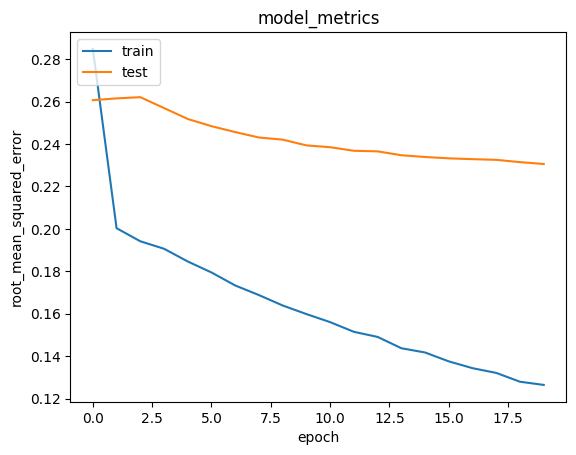

In [57]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Dapat diketahui proses training model cukup smooth pada 20 epochs. Dari proses ini, diperoleh nilai error akhir sebesar sekitar 0.12 dan error pada data validasi sekitar 0.23. Nilai tersebut cukup bagus untuk sebuah sistem rekomendasi.

### **Mendapatkan Rekomendasi Buku**


Untuk mendapatkan rekomendasi buku, pertama mengambil sampel user secara acak dan mendefinisikan variabel unreaded_Books yang merupakan daftar buku yang belum pernah dibaca oleh pengguna, unreaded_Books inilah yang akan menjadi buku yang direkomendasikan kepada pengguna.

Sebelumnya, pengguna telah memberi rating pada beberapa buku yang telah mereka baca. Rating ini digunakan untuk membuat rekomendasi buku yang mungkin cocok untuk pengguna. Buku yang akan direkomendasikan tentulah buku yang belum pernah dibaca oleh pengguna. Oleh karena itu, perlu membuat variabel unreaded_Books sebagai daftar buku untuk direkomendasikan pada pengguna.

Variabel unreaded_Books diperoleh dengan menggunakan operator bitwise (~) pada variabel readed_Books_by_Users.

In [60]:
Books_df = Books_new
df = all_Books_rate

# Mengambil sampel Users
Users_id = df['User-ID'].sample(40).iloc[10]
readed_Books_by_Users = df[df['User-ID'] == Users_id]

# Operator bitwise (~)
unreaded_Books = Books_df[~Books_df['id'].isin(readed_Books_by_Users.ISBN.values)]['id']
unreaded_Books = list(
    set(unreaded_Books)
    .intersection(set(Books_to_Books_encoded.keys()))
)

unreaded_Books = [[Books_to_Books_encoded.get(x)] for x in unreaded_Books]
Users_encoder = Users_to_Users_encoded.get(Users_id)
Users_Books_array = np.hstack(
    ([[Users_encoder]] * len(unreaded_Books), unreaded_Books)
)

Selanjutnya, memperoleh rekomendasi buku.

In [61]:
Ratings = model.predict(Users_Books_array).flatten()

top_Ratings_indices = Ratings.argsort()[-10:][::-1]
recommended_Books_ids = [
    Books_encoded_to_Books.get(unreaded_Books[x][0]) for x in top_Ratings_indices
]

print('\nRekomendasi buku untuk user: {}'. format(Users_id))
print('=' * 41)
print('\nBuku dengan rating tinggi dari user: {}'. format(Users_id))
print('=' * 41)

top_Books_Users = (
    readed_Books_by_Users.sort_values(
        by = 'Book-Rating',
        ascending=False
    )
    .head(5)
    ['ISBN'].values
)

Books_df_rows = Books_df[Books_df['id'].isin(top_Books_Users)]
for row in Books_df_rows.itertuples():
  print(row.Books_title, '||', row.Books_author)

print('\nTop 10 rekomendasi buku untuk user: {}'. format(Users_id))
print('=' * 41)

recommended_Books = Books_df[Books_df['id'].isin(recommended_Books_ids)]
for row in recommended_Books.itertuples():
  print(row.Books_title, '||', row.Books_author)

364/364 [==============================] - 1s 2ms/step

Rekomendasi buku untuk user: 7134

Buku dengan rating tinggi dari user: 7134
The Red Tent (Bestselling Backlist) || Anita Diamant
Allegra Maud Goldman || Edith Konecky
The Torn Skirt || Rebecca Godfrey
Ella Enchanted (Newbery Honor Book) || Gail Carson Levine
MAN IN THE QUEUE || Josephine Tey

Top 10 rekomendasi buku untuk user: 7134
The Da Vinci Code || Dan Brown
To Kill a Mockingbird || Harper Lee
Harry Potter and the Goblet of Fire (Book 4) || J. K. Rowling
Roses Are Red || James Patterson
The Time Traveler's Wife || Audrey Niffenegger
Nights in Rodanthe || Nicholas Sparks
Anne Frank: The Diary of a Young Girl || ANNE FRANK
The Handmaid's Tale || Margaret Atwood
Kushiel's Dart || Jacqueline Carey
The Spirit Catches You and You Fall Down || Anne Fadiman


Hasil di atas adalah rekomendasi untuk user dengan id 7134. Dari output tersebut, dapat melakukan perbandingan antara Buku dengan rating tinggi dari user: 7134 dan Top 10 rekomendasi buku untuk user: 7134.